In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson


In [8]:
maxCapacity = 20 #states
maxCompCapacity = 5 #moves
discount = 0.9 #1

#lambda(mean) of applicant or requested costumers
applicantA = 3
applicantB = 4

#lambda(mean) of applicant or requested costumers
dispensedA = 3
dispensedB = 2

#rewards
receiveReward = 10
loseReward = 6 #2

actions = np.arange(-maxCompCapacity, maxCompCapacity + 1)

In [9]:
poisson_bound = 11

# Probability for poisson distribution
poissons = dict()

def densPoisson(n, mean):
    global poissons
    key = n * 10 + mean
    if key not in poissons:
        poissons[key] = poisson.pmf(n, mean)
    return poissons[key]

In [10]:
def expectedReturn(state, action, state_value):

    E = 0.0

    # cost for moving costumers
    E -= loseReward * abs(action)

    
    num_costumers_A = int(min(state[0] - action, maxCapacity))
    num_costumers_B  = int(min(state[1] + action, maxCapacity))

    for appl_in_A in range(poisson_bound):
        for appl_in_B in range(poisson_bound):

            appl_prob = densPoisson(appl_in_A, applicantA) *  densPoisson(appl_in_B, applicantB)

            costumers_A = num_costumers_A
            costumers_B = num_costumers_B

            num_applicable_A = min(costumers_A, appl_in_A)
            num_applicable_B = min(costumers_B, appl_in_B)


            R = (num_applicable_A + num_applicable_B) * receiveReward
            costumers_A -= num_applicable_A
            costumers_B -= num_applicable_B

            # if cons_dispensed_costumers:
            #     # get returned cars, those cars can be used for renting tomorrow
            #     dispensed_in_A = dispensedA
            #     dispensed_in_B = dispensedB
            #     costumers_A = min(costumers_A + dispensed_in_A, maxCapacity)
            #     costumers_B = min(costumers_B + dispensed_in_B, maxCapacity)
            #     E += prob * (R + discount * state_value[costumers_A, costumers_B])
            # else:
            for dispensed_in_A in range(poisson_bound):
                for dispensed_in_B in range(poisson_bound):
                    disp_prob = densPoisson(dispensed_in_A, dispensedA) * densPoisson(dispensed_in_B, dispensedB)
                    num_costumers_A_ = min(costumers_A + dispensed_in_A, maxCapacity)
                    num_costumers_B_ = min(costumers_B + dispensed_in_B, maxCapacity)
                    prob_t = disp_prob * appl_prob
                    E += prob_t * (R + discount * state_value[num_costumers_A_, num_costumers_B_])
    return E


Iteration 0
Iteration 1
Iteration 2
Iteration 3
Values:
 [[388.87010011 398.81584797 408.65691786 418.25910268 427.5019914
  436.31924688 444.69586891 452.6455737  460.19092611 467.35383695
  474.15365447 480.60795532 486.73599574 492.55184421 498.06850657
  503.29546592 508.23495137 512.87536951 517.18114602 521.082475
  524.87827767]
 [398.7141581  408.6716155  418.53425778 428.15432166 437.40580676
  446.22552609 454.6022536  462.55140247 470.09601138 477.25808888
  484.05699943 490.51031815 496.63729398 502.4519814  507.96737047
  513.19292965 518.13087857 522.7696247  527.07361174 530.97307642
  534.36532273]
 [408.0854932  418.04996179 427.92539877 437.55575484 446.81164063
  455.63174935 464.0071239  471.95423047 479.49643928 486.65586348
  493.45191857 499.9022146  506.02602826 511.83742585 517.34940192
  522.57142509 527.505715   532.14068599 536.44080846 540.33638891
  543.72487014]
 [416.55333731 426.51732232 436.39163327 446.02038555 455.2741465
  464.09139826 472.46308148 

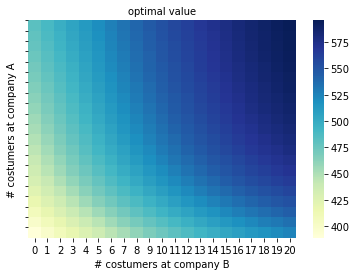

In [11]:
def mainLoop():
    value = np.zeros((maxCapacity + 1, maxCapacity + 1))
    policy = np.zeros(value.shape, dtype=np.int32)

    iteration = 0
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    while True:
        print('Iteration %d' % iteration)

        # policy evaluation (in-place)
        while True:
            prevValue = value.copy()
            for i in range(maxCapacity + 1):
                for j in range(maxCapacity + 1):
                    value[i, j] = expectedReturn([i, j], policy[i, j], value)
            maxChange = abs(prevValue - value).max()
            #1 for discount 0.9, 3 for discount 1 
            if maxChange < 3 :
                break

        # policy improvement
        allPoliciesUnchanged = True
        for i in range(maxCapacity + 1):
            for j in range(maxCapacity + 1):
                prevAction = policy[i, j]
                actionReturns = []
                for action in actions:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        actionReturns.append(expectedReturn([i, j], action, value))
                    else:
                        actionReturns.append(-np.inf)
                newAction = actions[np.argmax(actionReturns)]
                policy[i, j] = newAction
                if allPoliciesUnchanged and prevAction != newAction:
                    allPoliciesUnchanged = False
        # print('policy stable %s' % ('True' if allPoliciesUnchanged else 'False'))

        if allPoliciesUnchanged:
            fig = sns.heatmap(np.flipud(value), cmap="YlGnBu")
            fig.set_ylabel('# costumers at company A', fontsize=10)
            fig.set_yticks(list(reversed(range(maxCapacity + 1))))
            fig.set_xlabel('# costumers at company B', fontsize=10)
            fig.set_title('optimal value', fontsize=10)
            break

        iteration += 1

    print('Values:\n', value)
    print('Policies:\n', policy)
    plt.show()


if __name__ == '__main__':
    mainLoop()